#Segmentace zákazníků e-shopu


In [ ]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 


%matplotlib inline 
matplotlib.style.use('ggplot')

In [ ]:
data = pd.read_csv("eshop.csv")

In [ ]:
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22408 entries, 0 to 22407
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  22408 non-null  int64  
 1   Date         22408 non-null  object 
 2   Subtotal     22408 non-null  float64
 3   Country      22405 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 700.4+ KB


None

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


## Vytvoření RFM framu

   Datum si převedu na rozdíl mezi dnešním (19.12.2015) a datem ve sloupci -> tím získám počet dní od nákupu  
   Následně si groupnu řádky přes **Customer ID** a agreguji data:  
* **Recency** -> minimum z počtů dní od nákupu
* **Frequency** -> počet nákupů
* **Monetary** -> suma hodnot všech nákupů zákazníka

In [ ]:
#create rfm -> počet dnů od posledního nákupu,počet nákupů, celková suma
data["Recent"] = data["Date"].apply(lambda x: x.split("/"))
data["Recent"] = data["Recent"].apply(lambda x:  
                    (np.datetime64('2015-12-19') - np.datetime64(f'{x[2]}-{int(x[0]) :02d}-{int(x[1]) :02d}')).astype(int))

rfm = data[["Customer ID", "Recent", "Subtotal"]].groupby(['Customer ID']).agg({
    'Recent' : ['min', 'count' ],
    'Subtotal' : ['sum']
}).reset_index()

rfm.columns = ['ID', 'Recency', 'Frequency', 'Monetary']
rfm.drop(columns=['ID'], inplace = True)
display(rfm.info())
display(rfm.head(-10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12829 entries, 0 to 12828
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    12829 non-null  int64  
 1   Frequency  12829 non-null  int64  
 2   Monetary   12829 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 300.8 KB


None

,Recency,Frequency,Monetary
0,311,3,15.54
1,3050,1,13.20
2,3025,1,36.20
3,3103,1,86.00
4,3097,1,38.40
...,...,...,...
12814,2,1,93.28
12815,2,1,46.95
12816,2,1,55.20
12817,2,1,182.44


## Škálování

Původní data standartizuju pomocí **StandartScaler** a 
uložím si je do nového dataframu


In [ ]:
#scaling
scaler = StandardScaler()
s = scaler.fit_transform(rfm)
s_scaled_rfm= pd.DataFrame(s,columns=['Recency', 'Frequency', 'Monetary'])

## KMeans

  * Funkce bere jako vstupní parametr **RFM frame**
  * Postupně zkouší různé velikosti clusterů
  * Nakonec nakreslí graf, ve kterém můžeme hledat elbow
  * Funkce vrací výsledek po clusterování s určeným počtem clusterů

In [ ]:
def apply_k_means(rfm):
    
    max_size = 3**3
    ix = np.zeros(max_size)
    iy = np.zeros(max_size)

    for k in range(max_size):
        kmeans = KMeans(n_clusters = k+1, random_state = 42)
        kmeans.fit(rfm)
        iy[k] = kmeans.inertia_
        ix[k] = k+1

    plt.plot(ix,iy,'o-')
    plt.axvline(x=8)
    plt.show()


    kmeans = KMeans(n_clusters = 8, random_state = 42).fit(rfm)
    return kmeans

## Grafy

  * Funkce bere jako vstupní parametr **RFM frame** a **výsledek po clusterování**
  * Vykreslí grafy -> 3D graf a 3x 2D graf parametrů po dvojicích + legenda
  * Každý shluk má jinou barvu

In [ ]:
def plot_clusters(rfm, kmeans):
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')


    ax.scatter(rfm['Monetary'],rfm['Frequency'],rfm['Recency'], c=kmeans.labels_,cmap='turbo')

    ax.set_zlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Monetary')

    f, axes = plt.subplots(2, 2,figsize = (20,8))
    f.tight_layout()


    axes[0, 0].scatter(rfm['Monetary'],rfm['Frequency'], c=kmeans.labels_,cmap='turbo')

    axes[0, 1].scatter(rfm['Monetary'],rfm['Recency'], c=kmeans.labels_,cmap='turbo')

    axes[1, 0].scatter(rfm['Recency'],rfm['Frequency'], c=kmeans.labels_,cmap='turbo')

    arr = np.arange(8)

    axes[1, 1].scatter(arr,arr,np.ones(8) * 3000, c=arr,cmap='turbo')



    axes[0, 0].set_xlabel('Monetary')
    axes[0, 0].set_ylabel('Frequency')


    axes[0, 1].set_xlabel('Monetary')
    axes[0, 1].set_ylabel('Recency')


    axes[1, 0].set_xlabel('Recency')
    axes[1, 0].set_ylabel('Frequency')

    axes[1, 1].set_xlabel('LEGEND')
    axes[1, 1].set_ylabel('LEGEND')   

===NON-SCALED===


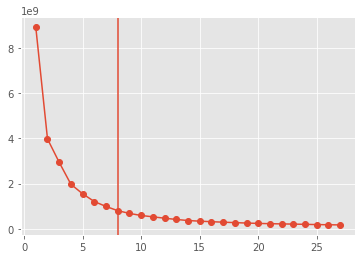

===NON-SCALED===


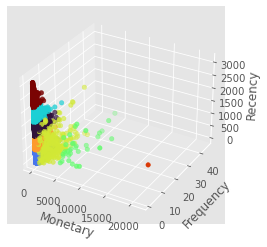

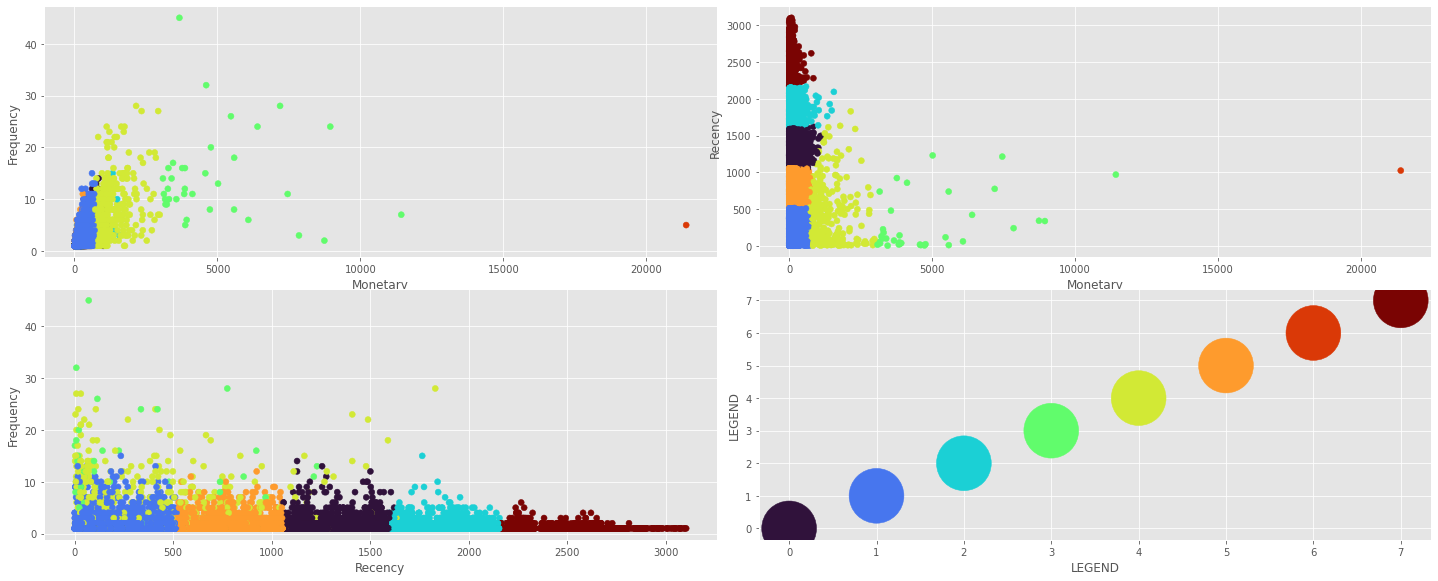

In [ ]:
print("===NON-SCALED===")
k1 = apply_k_means(rfm)
plot_clusters(rfm,k1)
print("===NON-SCALED===")

===SCALED===


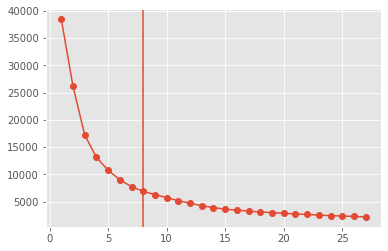

===SCALED===


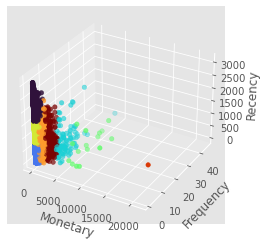

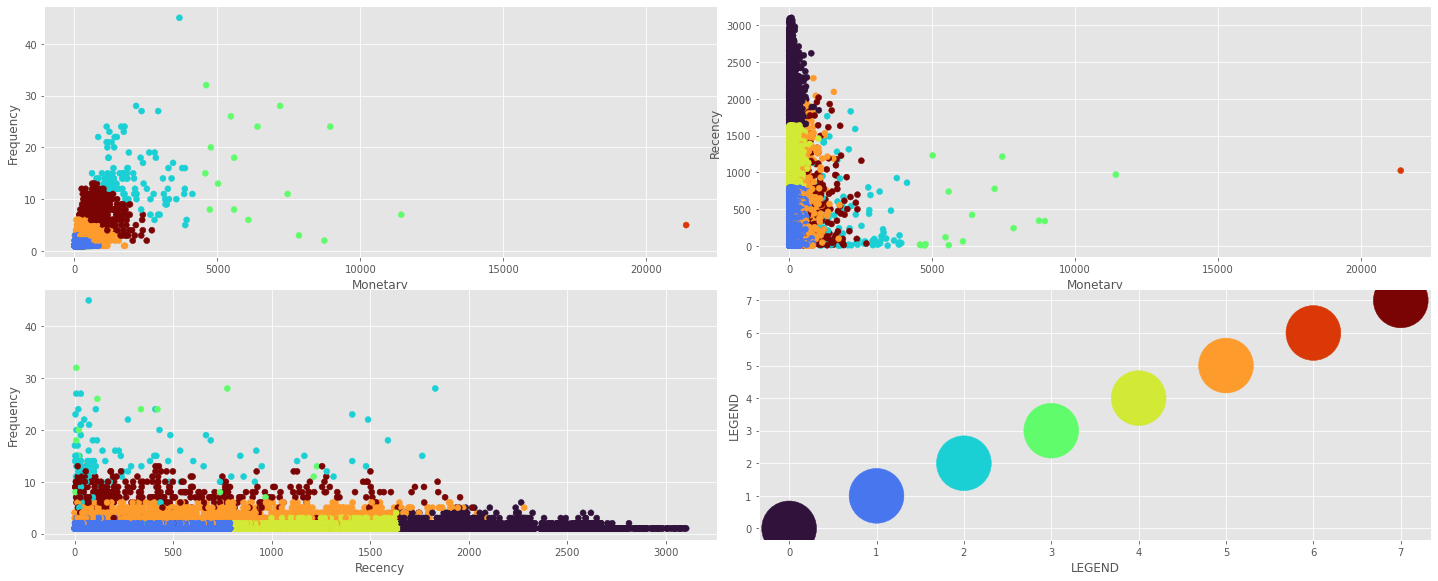

In [ ]:
print("===SCALED===")
k2 = apply_k_means(s_scaled_rfm)
plot_clusters(rfm,k2)
print("===SCALED===")

# Interpretace výsledků
* Na první pohled lze vidět, že škálování má vliv na výsledek. Neškálované data nejvíce ovlivňuje příznak Monetary.
* Z obou dat se nám podařilo klasifikovat dobré až nejlepší zákazníky.

In [ ]:
super_star = 6
stars = 3
good_scaled = 2
good_unscaled = 4
scaled_s = [super_star, stars,good_scaled]
unscaled_s = [super_star,stars, good_unscaled]

In [ ]:
new_rfm = rfm
new_rfm['Cluster'] = k1.labels_
#display(new_rfm.groupby('Cluster').mean())
new_rfm.head()
stars = new_rfm[rfm['Cluster']== 5]
#stars.head(20)

### Dobří zákazníci v neškálovaných datech
* V neškálovaných datech jsou:  
    * Cluster 6 : Nejlepší zákazníci -> v tomto případě jen jeden.  
    * Cluster 3 : Dobří zákazníci  
    * Cluster 4 : Nadprůměrní zákazníci  
* V Tabulce níže můžeme vidět průměry jednotlivých příznaků

In [ ]:
new_rfm = rfm
new_rfm['Cluster'] = k1.labels_
unscaled_good = new_rfm[new_rfm['Cluster'].isin(unscaled_s)]
display(unscaled_good.groupby('Cluster').mean())

,Recency,Frequency,Monetary
Cluster,,,
3,304.885714,14.257143,4897.449143
4,397.545198,8.098870,1254.385367
6,1024.000000,5.000000,21392.380000


### Dobří zákazníci ve škálovaných datech
* Ve škálovaných datech jsou:  
    * Cluster 6 : Nejlepší zákazníci -> v tomto případě jen jeden.  
    * Cluster 3 : Dobří zákazníci  
    * Cluster 2 : Nadprůměrní zákazníci  
* V Tabulce níže můžeme vidět průměry jednotlivých příznaků

In [ ]:
new_rfm = rfm
new_rfm['Cluster'] = k2.labels_
scaled_good = new_rfm[new_rfm['Cluster'].isin(scaled_s)]
display(scaled_good.groupby('Cluster').mean())

,Recency,Frequency,Monetary
Cluster,,,
2,326.772727,14.718182,1978.011273
3,406.437500,15.312500,6527.075625
6,1024.000000,5.000000,21392.380000
